In [1]:
import pickle
import numpy as np
np.set_printoptions(suppress=True, precision=1) 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scienceplots
from tqdm import tqdm
from shapely import LineString, Point
from seaborn import displot, histplot, relplot
plt.style.use(['nature'])

from scipy import stats
from waymo_devkit.conflict import Conflict

In [3]:
with open('./pkl/conflict_pet15s.pkl', 'rb') as file:
    conflict_list_from_pickle = pickle.load(file)
print(f"#Conflicts: {len(conflict_list_from_pickle)}")

conflict_list = list()
for c in conflict_list_from_pickle:
    conflict_list.append(
        Conflict(
            leader_id=c['leader_id'],
            leader_index=c['leader_index'],
            leader_states=c['leader_states'],
            leader_time_at_conflict=c['leader_time_at_conflict'],
            follower_id=c['follower_id'],
            follower_index=c['follower_index'],
            follower_states=c['follower_states'],
            follower_time_at_conflict=c['follower_time_at_conflict'],
            PET=c['PET'],
            conflict_type=c['conflict_type'],
            leader_is_av=c['leader_is_av'],
            follower_is_av=c['follower_is_av'],
            center=c['center'],
            radius=c['radius'],
            tfrecord_index=c['tfrecord_index'],
            scenario_index=c['scenario_index'],
    ))

#Conflicts: 889


In [4]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET"
]

# generate each rows in the dataframe
conflict_rows_in_df = list()
for index, conflict in tqdm(enumerate(conflict_list)):

    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    conflict_rows_in_df.append([
        conflict_type,
        leader_type+"-"+follower_type,
        conflict.PET,
    ])
conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

conflict_df.to_csv("./outputs/waymo_pet.csv", index=False)

# display info
conflict_df.info()

889it [00:00, 873854.29it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 0 to 888
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  864 non-null    object 
 1   Vehicle order  864 non-null    object 
 2   PET            864 non-null    float64
dtypes: float64(1), object(2)
memory usage: 27.0+ KB


report the number of scenarios for merging and crossing

In [4]:
conflict_df[["Conflict type", "Vehicle order"]].value_counts()

Conflict type  Vehicle order
Cross          HV-HV            283
               AV-HV            149
               HV-AV            142
Merge          AV-HV            135
               HV-HV            107
               HV-AV             48
dtype: int64

In [5]:
conflict_df[["Conflict type"]].value_counts()

Conflict type
Cross            574
Merge            290
dtype: int64

In [6]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['PET'].mean()

Conflict type  Vehicle order
Cross          AV-HV            3.832886
               HV-AV            5.326761
               HV-HV            4.081979
Merge          AV-HV            3.433333
               HV-AV            4.725000
               HV-HV            3.969159
Name: PET, dtype: float64

In [7]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['PET'].std()

Conflict type  Vehicle order
Cross          AV-HV            1.460768
               HV-AV            1.735647
               HV-HV            1.524874
Merge          AV-HV            0.965989
               HV-AV            1.688824
               HV-HV            1.876288
Name: PET, dtype: float64

In [8]:
cross_df = conflict_df[conflict_df["Conflict type"] == "Cross"]
merge_df = conflict_df[conflict_df["Conflict type"] == "Merge"]

HVHV_cross = cross_df[cross_df["Vehicle order"] == "HV-HV"]
AVHV_cross = cross_df[cross_df["Vehicle order"] == "AV-HV"]
HVAV_cross = cross_df[cross_df["Vehicle order"] == "HV-AV"]

HVHV_merge = merge_df[merge_df["Vehicle order"] == "HV-HV"]
AVHV_merge = merge_df[merge_df["Vehicle order"] == "AV-HV"]
HVAV_merge = merge_df[merge_df["Vehicle order"] == "HV-AV"]

## ANOVA

In [9]:
stats.f_oneway(HVHV_merge.PET, HVAV_merge.PET, AVHV_merge.PET)

F_onewayResult(statistic=14.003469801963691, pvalue=1.5743988355364758e-06)

In [10]:
stats.f_oneway(HVHV_cross.PET, HVAV_cross.PET, AVHV_cross.PET)

F_onewayResult(statistic=39.93289125313939, pvalue=5.858719427869532e-17)

## T test

In [10]:
# HVHV_cross, HVAV_cross
stats.ttest_ind(HVHV_cross.PET, HVAV_cross.PET)

Ttest_indResult(statistic=-7.573535808667401, pvalue=2.304947297040081e-13)

In [11]:
# HVHV_merge, HVAV_merge
stats.ttest_ind(HVHV_merge.PET, HVAV_merge.PET)

Ttest_indResult(statistic=-2.3896014063460407, pvalue=0.018084114022118538)

In [12]:
# HVHV_cross, AVHV_cross
stats.ttest_ind(HVHV_cross.PET, AVHV_cross.PET)

Ttest_indResult(statistic=1.6372410152007477, pvalue=0.10231169574430166)

In [13]:
# HVHV_merge, AVHV_merge
stats.ttest_ind(HVHV_merge.PET, AVHV_merge.PET)

Ttest_indResult(statistic=2.873258361457282, pvalue=0.004426639646748311)

In [14]:
# HVAV_cross, AVHV_cross
stats.ttest_ind(HVAV_cross.PET, AVHV_cross.PET)

Ttest_indResult(statistic=7.957408722748365, pvalue=4.0223846758020117e-14)

In [15]:
# HVAV_merge, AVHV_merge
stats.ttest_ind(HVAV_merge.PET, AVHV_merge.PET)

Ttest_indResult(statistic=6.424308266472839, pvalue=1.1354031857827542e-09)

## Mann-Whitney U test

Cross

In [16]:
stats.mannwhitneyu(
    x=HVHV_cross.PET,
    y=HVAV_cross.PET,
    alternative='two-sided'
) # pvalue=3.094463244674448e-15

MannwhitneyuResult(statistic=10673.5, pvalue=3.094463244674448e-15)

In [17]:
stats.mannwhitneyu(
    x=HVHV_cross.PET,
    y=AVHV_cross.PET,
    alternative='two-sided'
) # pvalue=0.0829966601282357

MannwhitneyuResult(statistic=23222.0, pvalue=0.0829966601282357)

In [19]:
stats.mannwhitneyu(
    x=HVAV_cross.PET,
    y=AVHV_cross.PET,
    alternative='two-sided'
) # pvalue=6.321654319067501e-16

MannwhitneyuResult(statistic=16378.5, pvalue=6.321654319067501e-16)

Merge

In [20]:
stats.mannwhitneyu(
    x=HVHV_merge.PET,
    y=HVAV_merge.PET,
    alternative='two-sided'
) # 0.0010638774198889096

MannwhitneyuResult(statistic=1722.0, pvalue=0.0010638774198889096)

In [21]:
stats.mannwhitneyu(
    x=HVHV_merge.PET,
    y=AVHV_merge.PET,
    alternative='two-sided'
) # pvalue=0.10402100769180175

MannwhitneyuResult(statistic=8102.0, pvalue=0.10402100769180175)

In [23]:
stats.mannwhitneyu(
    x=HVAV_merge.PET,
    y=AVHV_merge.PET,
    alternative='two-sided'
) # pvalue=1.4800319690948374e-07

MannwhitneyuResult(statistic=4896.5, pvalue=1.4800319690948374e-07)

## Draw distributions

### All

<Figure size 300x300 with 0 Axes>

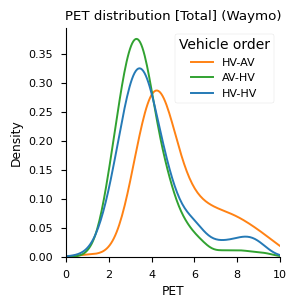

In [4]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

HVHV_COLOR = '#257ab6'
HVAV_COLOR = '#31a231'
AVHV_COLOR = '#ff8214'

FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df,
    x="PET", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0,PET_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title("PET distribution [Total] (Waymo)")
# plt.savefig("./outputs/plots/waymo_distribution_PET_Total.png", dpi=300, bbox_inches="tight")
plt.show()

### Merge

<Figure size 300x300 with 0 Axes>

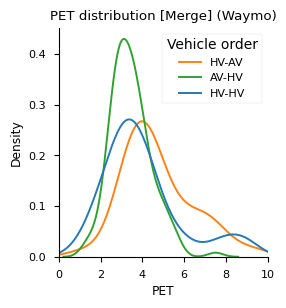

In [5]:
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df[conflict_df["Conflict type"]=="Merge"],
    x="PET", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0,PET_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title("PET distribution [Merge] (Waymo)")
# plt.savefig("./outputs/plots/waymo_distribution_PET_Merge.png", dpi=300, bbox_inches="tight")
plt.show()

### Cross

<Figure size 300x300 with 0 Axes>

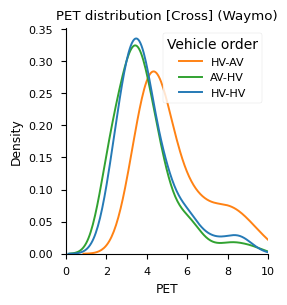

In [6]:
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df[conflict_df["Conflict type"]=="Cross"],
    x="PET", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0,PET_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title("PET distribution [Cross] (Waymo)")
# plt.savefig("./outputs/plots/waymo_distribution_PET_Cross.png", dpi=300, bbox_inches="tight")
plt.show()

## Histplots

### All

<Figure size 900x300 with 0 Axes>

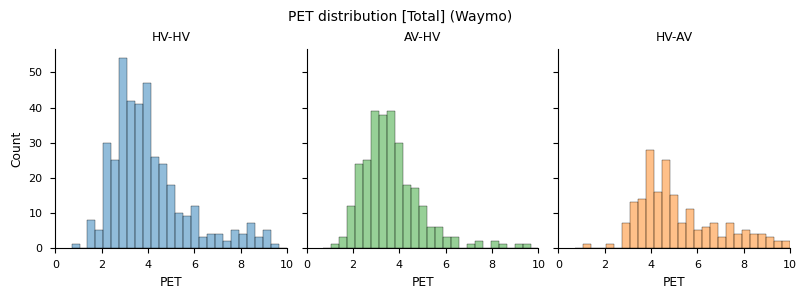

In [7]:
plt.figure(figsize=(FIGURE_WIDTH * 3, FIGURE_HEIGHT))

g = displot(
    data=conflict_df,
    x="PET", 
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    hue="Vehicle order",
    kind="hist",
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=0.9,
    legend=False,
)

plt.xlim([0,PET_THRESHOLD])
# suptitle and its location
g.set_titles("{col_name}")
g.fig.suptitle("PET distribution [Total] (Waymo)", size=10)
g.figure.subplots_adjust(top=.85)

plt.savefig("./outputs/plots/waymo_histogram_PET_all.png", dpi=300, bbox_inches="tight")
plt.show()

### Merge

<Figure size 900x300 with 0 Axes>

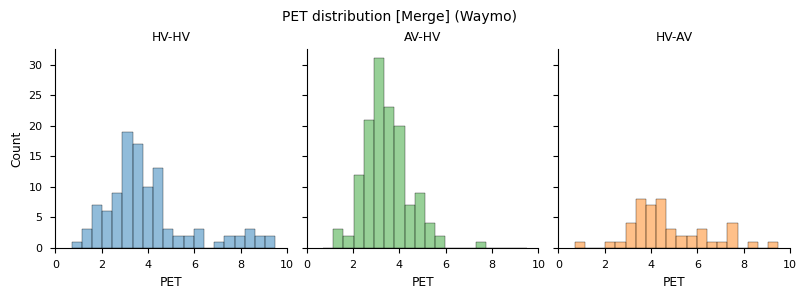

In [8]:
plt.figure(figsize=(FIGURE_WIDTH * 3, FIGURE_HEIGHT))

g = displot(
    data=conflict_df[conflict_df["Conflict type"]=="Merge"],
    x="PET", 
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    hue="Vehicle order",
    kind="hist",
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=0.9,
    legend=False,
)

plt.xlim([0,PET_THRESHOLD])
# suptitle and its location
g.set_titles("{col_name}")
g.fig.suptitle("PET distribution [Merge] (Waymo)", size=10)
g.figure.subplots_adjust(top=.85)

plt.savefig("./outputs/plots/waymo_histogram_PET_merge.png", dpi=300, bbox_inches="tight")
plt.show()

### Cross

<Figure size 900x300 with 0 Axes>

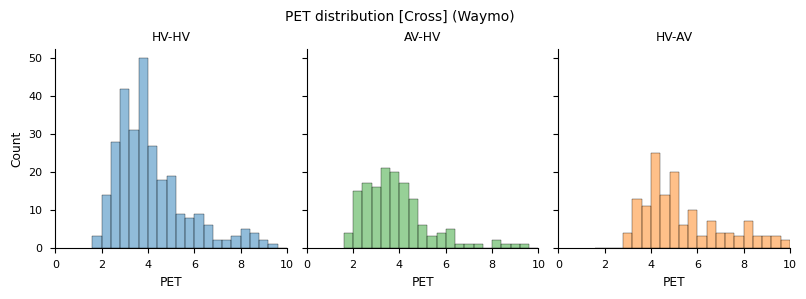

In [9]:
plt.figure(figsize=(FIGURE_WIDTH * 3, FIGURE_HEIGHT))

g = displot(
    data=conflict_df[conflict_df["Conflict type"] == "Cross"],
    x="PET", 
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    hue="Vehicle order",
    kind="hist",
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=0.9,
    legend=False,
)

plt.xlim([0,PET_THRESHOLD])
# suptitle and its location
g.set_titles("{col_name}")
g.fig.suptitle("PET distribution [Cross] (Waymo)", size=10)
g.figure.subplots_adjust(top=.85)

plt.savefig("./outputs/plots/waymo_histogram_PET_cross.png", dpi=300, bbox_inches="tight")
plt.show()